In [1]:
import tensorflow as tf

import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten,  Dropout, SpatialDropout2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

from tensorflow.keras.preprocessing import image

In [2]:
tf.__version__

'2.20.0'

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [4]:
training_set = train_datagen.flow_from_directory(r'C:\Users\user\Desktop\DATA\training_set\training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 8000 images belonging to 2 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(r'C:\Users\user\Desktop\DATA\test_set\test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [6]:
def create_model(trial):
    model = Sequential()
    
    """ Convolutional Neural Network """
    
    filters1 = trial.suggest_int('filters1', 16, 128)
    filters2 = trial.suggest_int('filters2', 16, 128)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    pool_size = trial.suggest_int('pool_size', 2, 3)
    strides = trial.suggest_int('strides', 1, 2)
    spatial_dropout_conv1 = trial.suggest_float("dropout_conv1", 0.1, 0.2)
    spatial_dropout_conv2 = trial.suggest_float("dropout_conv2", 0.1, 0.2)
    
    model.add(Conv2D(filters=filters1, kernel_size=kernel_size, activation='relu', input_shape=[64, 64, 3]))
    model.add(MaxPool2D(pool_size=pool_size, strides=strides))
    model.add(SpatialDropout2D(spatial_dropout_conv1))  
    
    model.add(Conv2D(filters=filters2, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPool2D(pool_size=pool_size, strides=strides))
    model.add(SpatialDropout2D(spatial_dropout_conv2)) 
    
    model.add(Flatten())
    
    """ Artificial Neural Network """
    
    model.add(Dense(units=trial.suggest_int('units_layer1', 6, 128), activation='relu'))
    model.add(Dropout(trial.suggest_float("dropout_ann1", 0.1, 0.5)))  
    
    model.add(Dense(units=trial.suggest_int('units_layer2', 6, 128), activation='relu'))
    model.add(Dropout(trial.suggest_float("dropout_ann2", 0.1, 0.5))) 
    
    model.add(Dense(units=1, activation='sigmoid'))
    
    """ Suggest hyperparameters for the optimizer """
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['auc'])
    
    return model


In [7]:
from optuna.samplers import TPESampler

def optimal(trial):
    model = create_model(trial)
    
    history = model.fit(training_set, validation_data=test_set, epochs=20, batch_size=trial.suggest_int('batch_size', 16, 64))
    
    test_loss, test_auc = model.evaluate(test_set, verbose=0)
    
    return test_auc

tpe_sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=tpe_sampler)

study.optimize(optimal, n_trials=2)

print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

[I 2025-10-04 14:34:32,882] A new study created in memory with name: no-name-aef56b56-0056-4a02-adb3-015b20de7a56
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 653s 3s/step - auc: 0.5344 - loss: 0.6970 - val_auc: 0.6734 - val_loss: 0.6764
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - auc: 0.5961 - loss: 0.6803 - val_auc: 0.7218 - val_loss: 0.6595
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - auc: 0.6675 - loss: 0.6512 - val_auc: 0.7517 - val_loss: 0.6325
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - auc: 0.7026 - loss: 0.6307 - val_auc: 0.7670 - val_loss: 0.6076
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - auc: 0.7274 - loss: 0.6123 - val_auc: 0.7857 - val_loss: 0.5944
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - auc: 0.7489 - loss: 0.5944 - val_auc: 0.7992 - val_loss: 0.5641
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - auc: 0.7621 - loss: 0.5826 - val_auc: 0.8107 - val_loss: 0.5731
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - auc: 0.7743 - loss: 0.5702 - val_auc: 0.8151 - val_loss: 0.5730
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/

[I 2025-10-04 16:34:30,067] Trial 0 finished with value: 0.8647060394287109 and parameters: {'filters1': 58, 'filters2': 123, 'kernel_size': 4, 'pool_size': 3, 'strides': 1, 'dropout_conv1': 0.11559945203362026, 'dropout_conv2': 0.10580836121681995, 'units_layer1': 112, 'dropout_ann1': 0.34044600469728353, 'units_layer2': 93, 'dropout_ann2': 0.10823379771832098, 'optimizer': 'adam', 'learning_rate': 3.5498788321965036e-05, 'batch_size': 30}. Best is trial 0 with value: 0.8647060394287109.


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 425ms/step - auc: 0.5146 - loss: 0.6962 - val_auc: 0.6473 - val_loss: 0.6910
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 106s 424ms/step - auc: 0.5328 - loss: 0.6915 - val_auc: 0.6811 - val_loss: 0.6850
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 106s 424ms/step - auc: 0.5549 - loss: 0.6883 - val_auc: 0.6928 - val_loss: 0.6794
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 437ms/step - auc: 0.5780 - loss: 0.6838 - val_auc: 0.7015 - val_loss: 0.6702
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 106s 424ms/step - auc: 0.5997 - loss: 0.6783 - val_auc: 0.7040 - val_loss: 0.6578
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 427ms/step - auc: 0.6087 - loss: 0.6755 - val_auc: 0.7179 - val_loss: 0.6514
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 106s 426ms/step - auc: 0.6320 - loss: 0.6679 - val_auc: 0.7210 - val_loss: 0.6437
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 428ms/step - auc: 0.6430 - loss: 0.6627 - val_auc: 0.7284 - val_loss: 0.6389
Epoch 9/20
250/250 ━━━━━

[I 2025-10-04 17:10:48,973] Trial 1 finished with value: 0.7867230176925659 and parameters: {'filters1': 75, 'filters2': 64, 'kernel_size': 3, 'pool_size': 3, 'strides': 1, 'dropout_conv1': 0.12921446485352184, 'dropout_conv2': 0.1366361843293692, 'units_layer1': 62, 'dropout_ann1': 0.41407038455720546, 'units_layer2': 30, 'dropout_ann2': 0.3056937753654446, 'optimizer': 'rmsprop', 'learning_rate': 1.5673095467235405e-05, 'batch_size': 62}. Best is trial 0 with value: 0.8647060394287109.


Best trial: 0.8647060394287109
Best hyperparameters: {'filters1': 58, 'filters2': 123, 'kernel_size': 4, 'pool_size': 3, 'strides': 1, 'dropout_conv1': 0.11559945203362026, 'dropout_conv2': 0.10580836121681995, 'units_layer1': 112, 'dropout_ann1': 0.34044600469728353, 'units_layer2': 93, 'dropout_ann2': 0.10823379771832098, 'optimizer': 'adam', 'learning_rate': 3.5498788321965036e-05, 'batch_size': 30}


In [8]:
best_params = study.best_trial.params

best_params

{'filters1': 58,
 'filters2': 123,
 'kernel_size': 4,
 'pool_size': 3,
 'strides': 1,
 'dropout_conv1': 0.11559945203362026,
 'dropout_conv2': 0.10580836121681995,
 'units_layer1': 112,
 'dropout_ann1': 0.34044600469728353,
 'units_layer2': 93,
 'dropout_ann2': 0.10823379771832098,
 'optimizer': 'adam',
 'learning_rate': 3.5498788321965036e-05,
 'batch_size': 30}

In [9]:
def create_final_model(best_params):
    model = Sequential()
    
    """ Step 1. Convolutional layers with Dropout """
    
    model.add(Conv2D(filters=best_params['filters1'], kernel_size=best_params['kernel_size'], activation='relu', input_shape=[64, 64, 3]))
    model.add(MaxPool2D(pool_size=best_params['pool_size'], strides=best_params['strides']))
    model.add(Dropout(best_params['dropout_conv1']))
    
    model.add(Conv2D(filters=best_params['filters2'], kernel_size=best_params['kernel_size'], activation='relu'))
    model.add(MaxPool2D(pool_size=best_params['pool_size'], strides=best_params['strides']))
    model.add(Dropout(best_params['dropout_conv2']))  
    
    model.add(Flatten())
    
    """ Step 2. Fully connected layers with Dropout """
    
    model.add(Dense(units=best_params['units_layer1'], activation='relu'))
    model.add(Dropout(best_params['dropout_ann1'])) 
    
    model.add(Dense(units=best_params['units_layer2'], activation='relu'))
    model.add(Dropout(best_params['dropout_ann2'])) 
    
    model.add(Dense(units=1, activation='sigmoid'))
    
    """ Step 3. Optimizer with the best hyperparameters """
    
    learning_rate = best_params['learning_rate']
    
    if best_params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif best_params['optimizer'] == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif best_params['optimizer'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif best_params['optimizer'] == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    
    """ Step 4. Compile the model """
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['auc'])
    
    return model


In [10]:
fin_mod = create_final_model(best_params)

In [11]:
fin_mod.fit(
    training_set, 
    validation_data=test_set, 
    epochs=20,  
    batch_size=best_params['batch_size']
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - auc: 0.5542 - loss: 0.6908 - val_auc: 0.6779 - val_loss: 0.6790
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - auc: 0.6604 - loss: 0.6549 - val_auc: 0.7290 - val_loss: 0.6484
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - auc: 0.7149 - loss: 0.6229 - val_auc: 0.7641 - val_loss: 0.6155
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 249s 993ms/step - auc: 0.7429 - loss: 0.6017 - val_auc: 0.7813 - val_loss: 0.6064
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - auc: 0.7721 - loss: 0.5753 - val_auc: 0.8107 - val_loss: 0.5710
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 250s 999ms/step - auc: 0.7848 - loss: 0.5609 - val_auc: 0.8206 - val_loss: 0.5412
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 245s 979ms/step - auc: 0.7968 - loss: 0.5501 - val_auc: 0.8234 - val_loss: 0.5473
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - auc: 0.8118 - loss: 0.5306 - val_auc: 0.8302 - val_loss: 0.5299
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━

In [12]:
train_loss, train_auc = fin_mod.evaluate(training_set)
test_loss, test_auc = fin_mod.evaluate(test_set)

print(f"Train Loss: {train_loss}")
print(f"Train Auc: {train_auc}")
print(f"Test Loss: {test_loss}")
print(f"Test Auc: {test_auc}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - auc: 0.8823 - loss: 0.4638
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - auc: 0.8672 - loss: 0.5009
Train Loss: 0.463784396648407
Train Auc: 0.8822607398033142
Test Loss: 0.5008582472801208
Test Auc: 0.8671990036964417


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


,Image,Prediction
0,,dogs
1,,cats
2,,cats
3,,dogs
4,,cats
5,,cats
6,,cats
7,,cats
8,,dogs
9,,cats

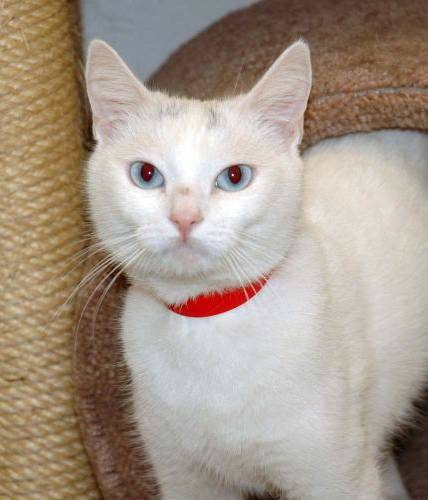
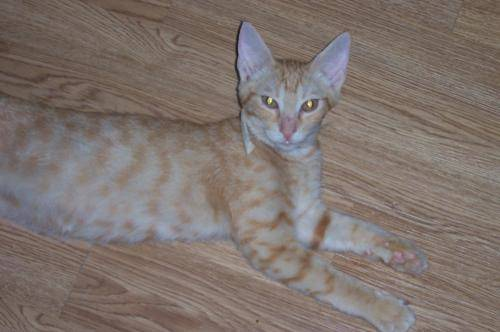
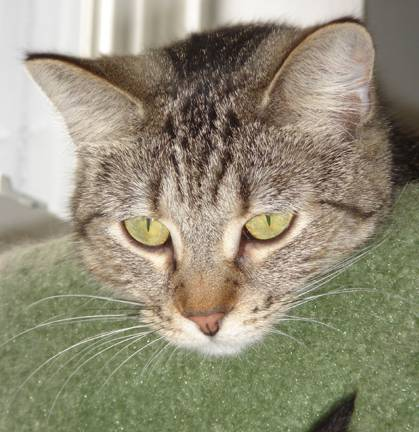
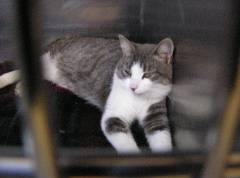
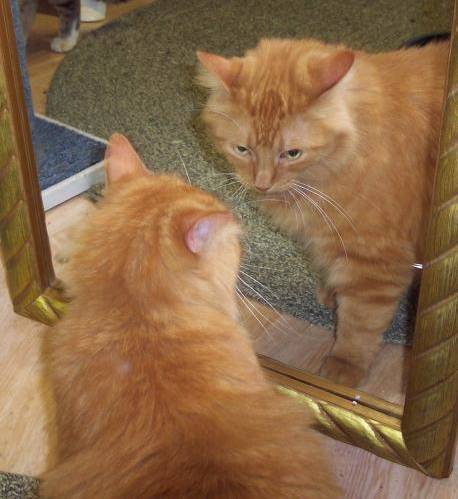
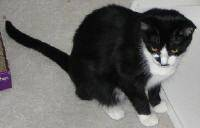
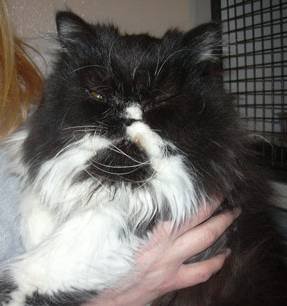
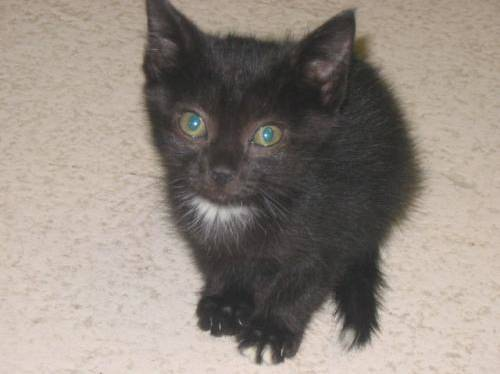
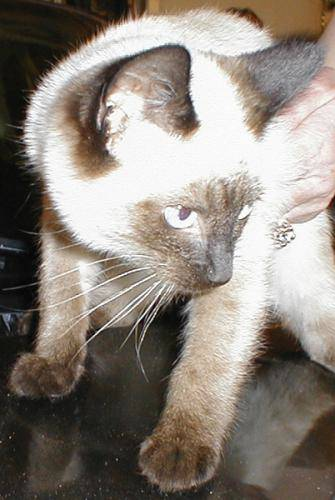
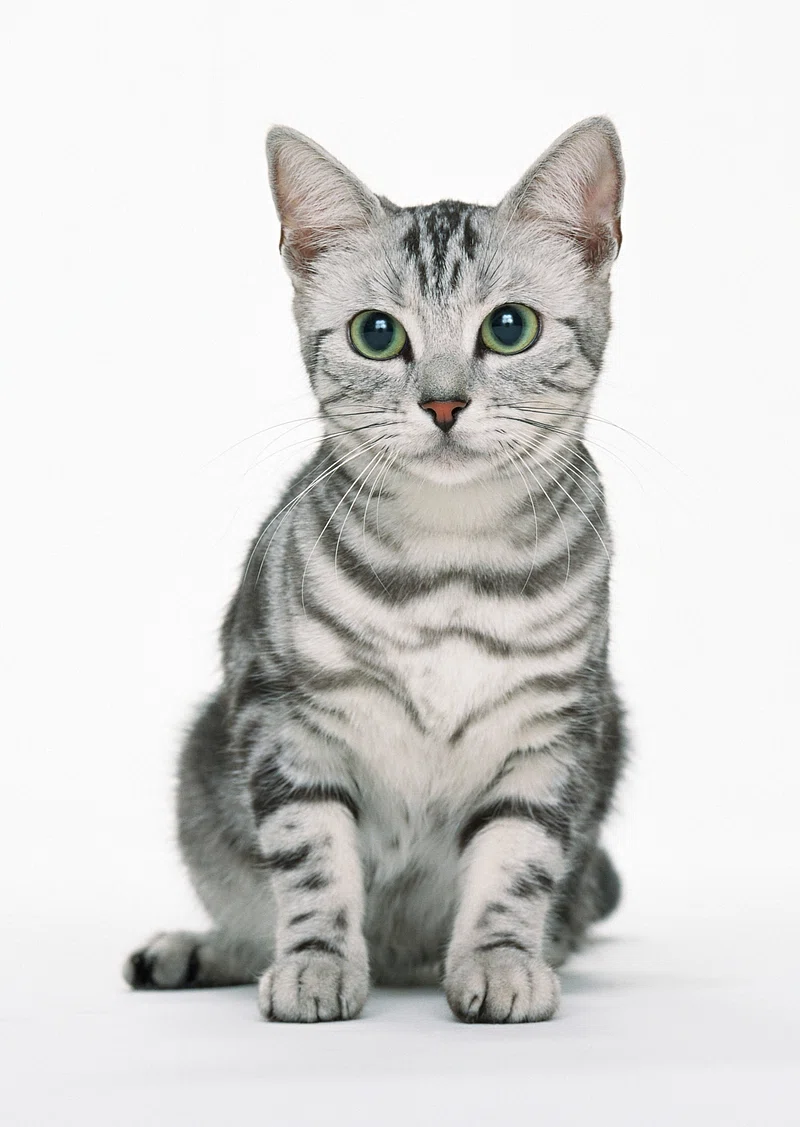
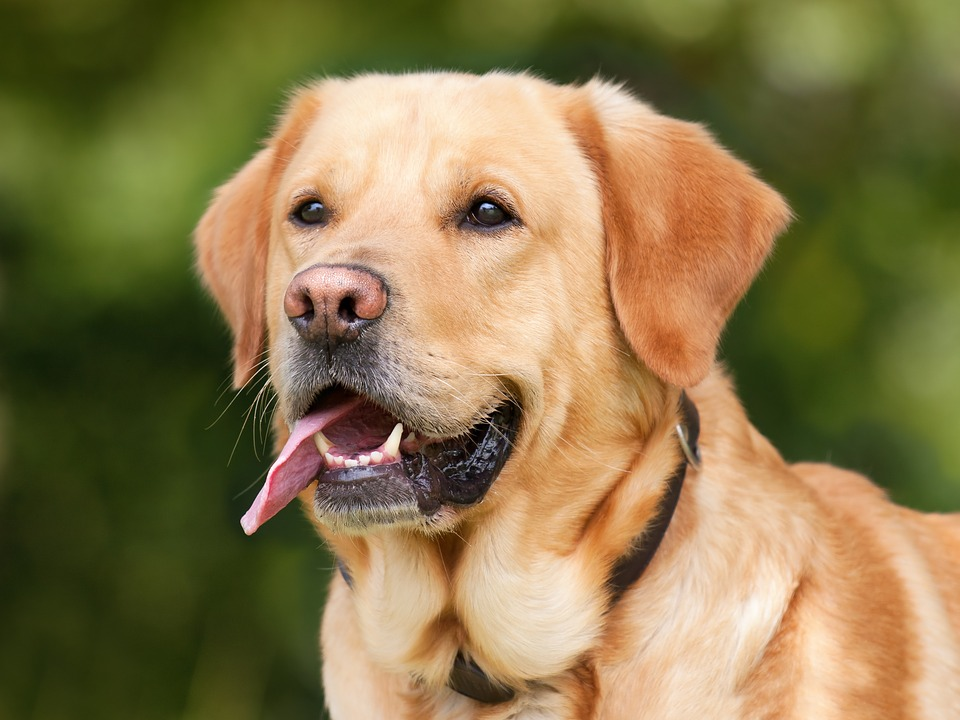
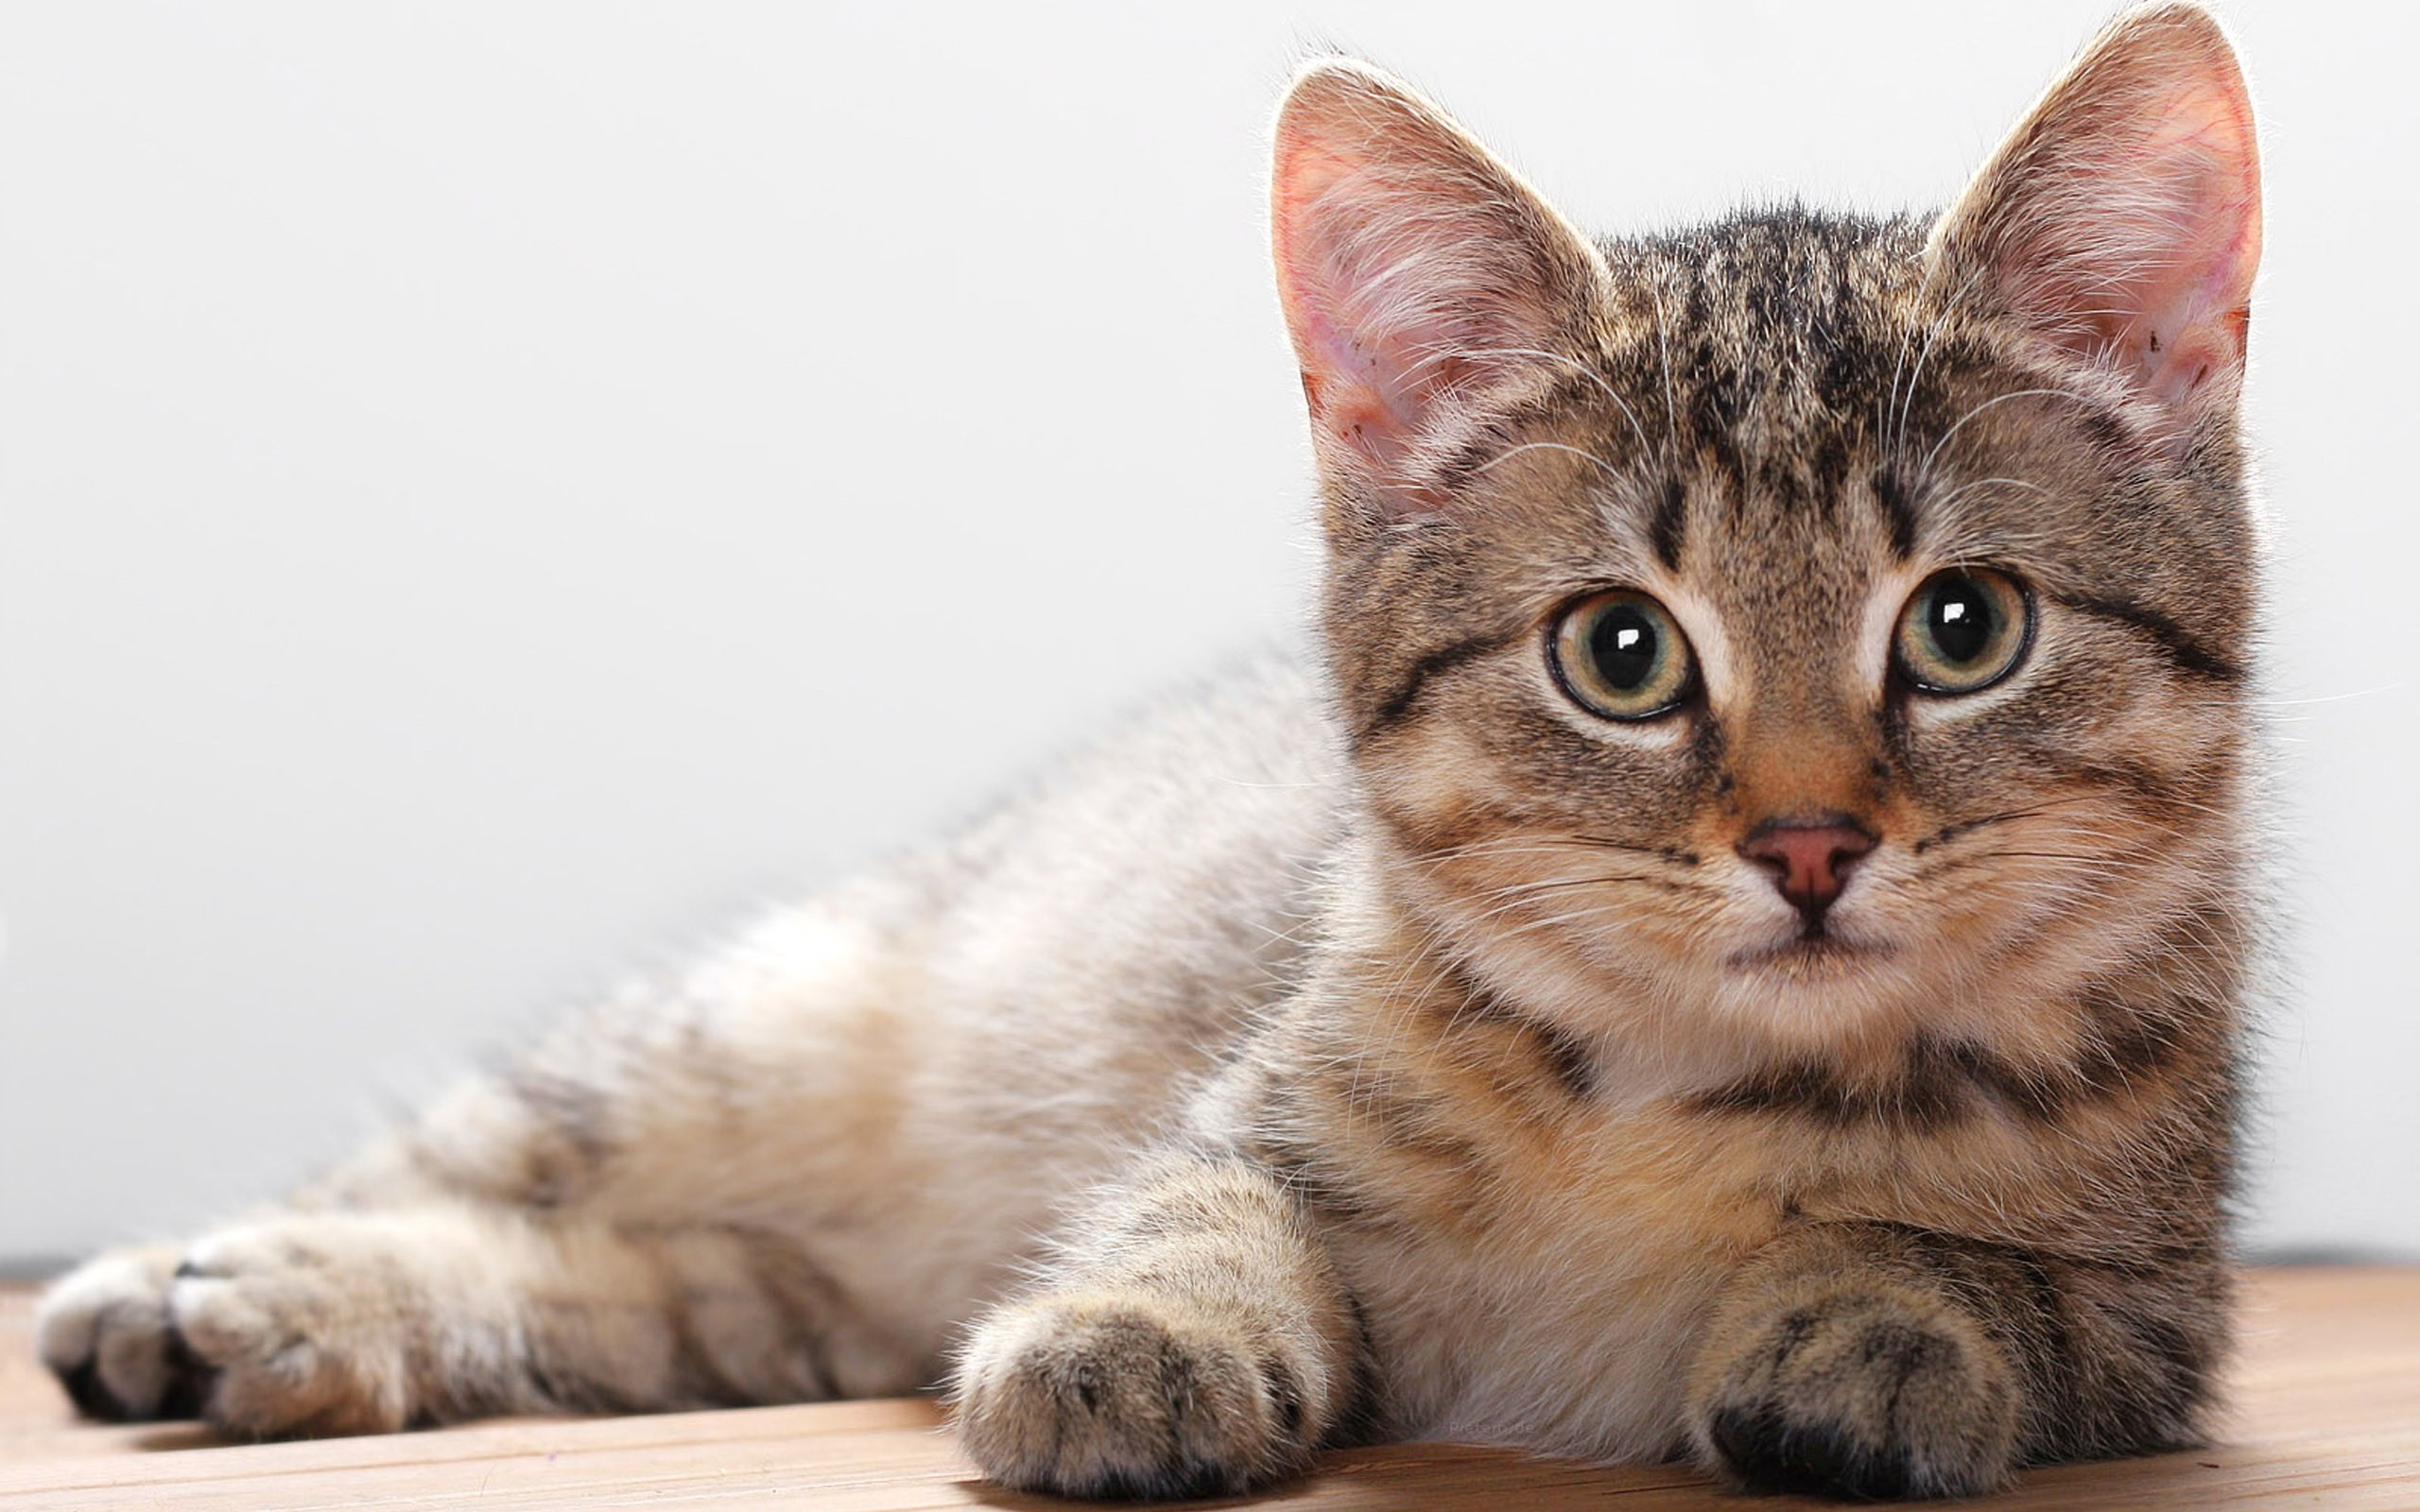
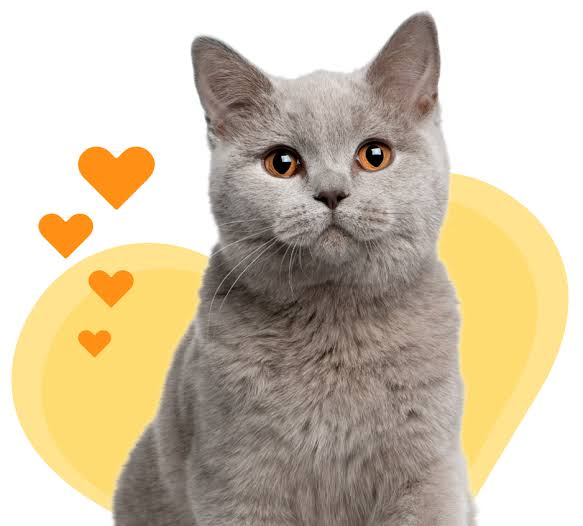
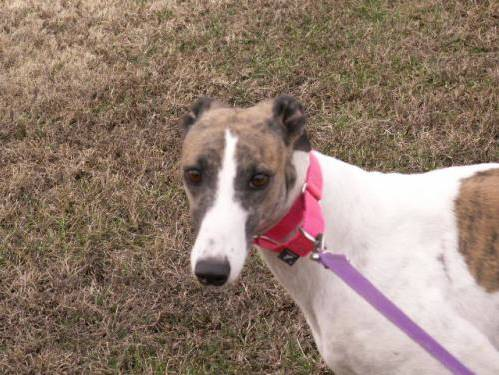
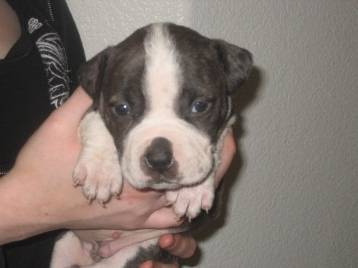
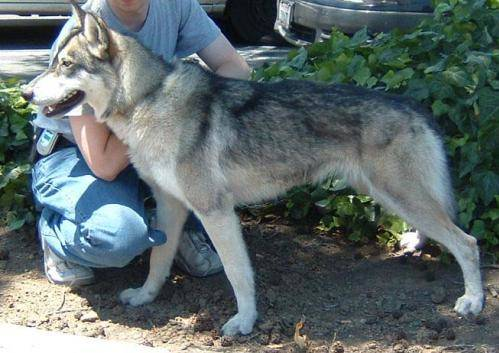
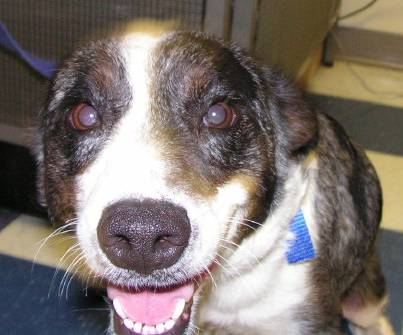
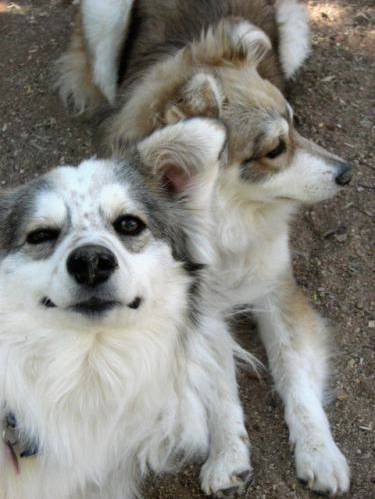
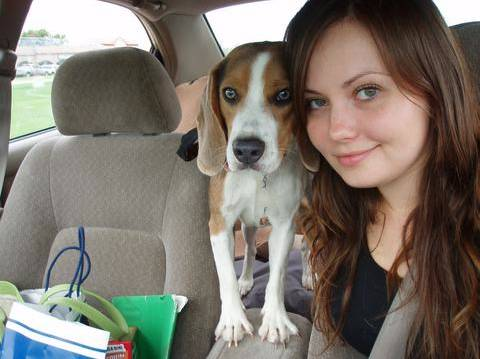
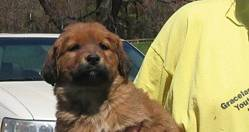
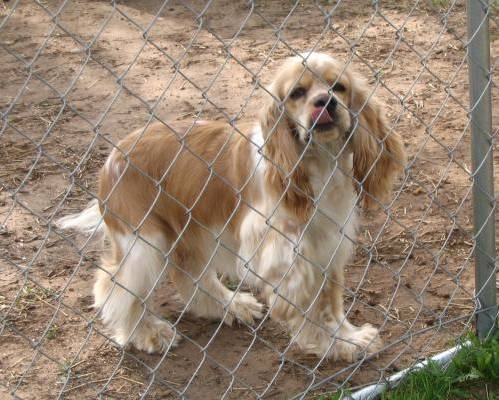

In [13]:
from IPython.display import Image, display
from io import BytesIO
import base64
import os
import numpy as np
import pandas as pd
from keras.preprocessing import image

def img_to_displayable_format(img_path):
    with open(img_path, "rb") as img_file:
        encoded_img = base64.b64encode(img_file.read()).decode('utf-8')
    return f'<img src="data:image/jpeg;base64,{encoded_img}" width="64" height="64"/>'

folder_path = r'C:\Users\user\Desktop\DATA\single_prediction\single_prediction'

results = []

# Reverse the dictionary to map from indices back to class names
class_names = {v: k for k, v in training_set.class_indices.items()}

for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.webp')):
        
        img_path = os.path.join(folder_path, filename)
        test_image = image.load_img(img_path, target_size=(64, 64))
        test_image_array = image.img_to_array(test_image)
        test_image_array = np.expand_dims(test_image_array, axis=0)

        result = fin_mod.predict(test_image_array / 255.0)

        predicted_class_index = 1 if result[0][0] > 0.5 else 0
        prediction = class_names[predicted_class_index]

        img_display = img_to_displayable_format(img_path)
        results.append({'Image': img_display, 'Prediction': prediction})

df_results = pd.DataFrame(results)

from IPython.display import display, HTML
display(HTML(df_results.to_html(escape=False)))
